# Mental Health Survey Social Analysis

In [40]:
# Setting up environment
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.express as px
import numpy as np
import os

# Modeling Libraries
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import statsmodels.formula.api as smf
from sklearn import metrics
from statistics import mean
from math import isnan
from itertools import filterfalse

In [27]:
# os.chdir("E:\MSBA WINTER 23\BANA 277")

### Setting up dataframe and cleaning

In [3]:
# Reading datafile
df = pd.read_csv("survey.csv")
display(df)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2015-09-12 11:17:21,26,male,United Kingdom,NaN,No,No,Yes,NaN,26-100,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
1255,2015-09-26 01:07:35,32,Male,United States,IL,No,Yes,Yes,Often,26-100,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,NaN
1256,2015-11-07 12:36:58,34,male,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,NaN
1257,2015-11-30 21:25:06,46,f,United States,NC,No,No,No,NaN,100-500,...,Don't know,Yes,No,No,No,No,No,No,No,NaN


In [4]:
# Dropping columns because if irrelevancy, then looking at the amount of null values in data
df = df.drop(["comments","state","Timestamp"], axis=1)
df.isnull().sum()

Age                            0
Gender                         0
Country                        0
self_employed                 18
family_history                 0
treatment                      0
work_interfere               264
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
dtype: int64

In [5]:
# Cleaning data, giving default value for each data for NA values
defInt = 0
defStr = "NA"
defFl = 0.0
integer_col = ["Age"]
string_coldf = df[df.columns.difference(["Age"])]
string_col = string_coldf.columns.tolist()
float_col = []
for feature in df:
    if feature in integer_col:
        df[feature] = df[feature].fillna(defInt)
    elif feature in string_col:
        df[feature]= df[feature].fillna(defStr)
    elif feature in float_col:
        df[feature] = df[feature].fillna(defFl)
    else:
        print("No feature")
display(df)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NA,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NA,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NA,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NA,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NA,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,26,male,United Kingdom,No,No,Yes,NA,26-100,No,Yes,...,Don't know,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No
1255,32,Male,United States,No,Yes,Yes,Often,26-100,Yes,Yes,...,Yes,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No
1256,34,male,United States,No,Yes,Yes,Sometimes,More than 1000,No,Yes,...,Don't know,Somewhat difficult,Yes,Yes,No,No,No,No,No,No
1257,46,f,United States,No,No,No,NA,100-500,Yes,Yes,...,Don't know,Don't know,Yes,No,No,No,No,No,No,No


In [6]:
# Cleaning Gender Column to categorize into male, female, and trans
gender = df.Gender.str.lower()
gender = df.Gender.unique()
str_male = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
str_trans = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
str_female = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]
for (row, col) in df.iterrows():

    if str.lower(col.Gender) in str_male:
        df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in str_female:
        df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in str_trans:
        df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

value = ["A little about you", "p"]
df = df[df.Gender.isin(value)==False]

In [7]:
# Cleaning Age column
# Filling NA values with median
df.Age.fillna(df.Age.median(),inplace= True)
# People should be of working age, so change all the values that are below 18 and above 100 to median
agemed= df.Age.median()
df["Age"].values[df["Age"] < 18] = agemed
df["Age"].values[df["Age"] > 100] = agemed

In [8]:
# All NA data values of self employed and work interfere will be assumed to be No
df["self_employed"] = df["self_employed"].replace("NA", "No")
df["work_interfere"] = df["work_interfere"].replace("NA", "No")

In [9]:
# Putting categorical values to binomial
df["self_employed"] = df.self_employed.apply(lambda x: 0 if x == "No" else 1)
df["treatment"] = df.treatment.apply(lambda x: 0 if x == "No" else 1)
df["family_history"] = df.family_history.apply(lambda x: 0 if x == "No" else 1)
df["remote_work"] = df.remote_work.apply(lambda x: 0 if x == "No" else 1)
df["tech_company"] = df.tech_company.apply(lambda x: 0 if x == "No" else 1)
df["obs_consequence"] = df.obs_consequence.apply(lambda x: 0 if x == "No" else 1)
df.head()

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,female,United States,0,0,1,Often,6-25,0,1,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,0
1,44,male,United States,0,0,0,Rarely,More than 1000,0,0,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,0
2,32,male,Canada,0,0,0,Rarely,6-25,0,1,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,0
3,31,male,United Kingdom,0,1,1,Often,26-100,0,1,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,1
4,31,male,United States,0,0,0,Never,100-500,1,1,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,0


In [10]:
# Creating dummy variables for other columns to make numerical values
dvcol = pd.get_dummies(df[["Gender","work_interfere","no_employees","benefits","care_options","wellness_program",
            "seek_help","anonymity","leave","mental_health_consequence","phys_health_consequence",
            "coworkers","supervisor","mental_health_interview","phys_health_interview",
            "mental_vs_physical"]])
display(dvcol)

,Gender_female,Gender_male,Gender_trans,work_interfere_Never,work_interfere_No,work_interfere_Often,work_interfere_Rarely,work_interfere_Sometimes,no_employees_1-5,no_employees_100-500,...,supervisor_Yes,mental_health_interview_Maybe,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes
0,1,0,0,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,0,1,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
4,0,1,0,1,0,0,0,0,0,1,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
1255,0,1,0,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
1256,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
1257,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0


In [11]:
# Creating final dataframe to combine dummy variable set and copied version of data
df_final = df
df_final = pd.concat([df_final, dvcol], axis = 1)

In [12]:
#Renaming Columns 
df_final.rename(columns = {"benefits_Don't know":'benefits_Dont_Know', "wellness_program_Don't know":'wellness_program_Dont_know',
                           "seek_help_Don't know":"seek_help_Dont_know", "anonymity_Don't know": "anonymity_Dont_know",
                           "leave_Don't know":"leave_Dont_know","mental_vs_physical_Don't know":"mental_vs_physical_Dont_know"}, inplace = True)

In [13]:
# Dropping columsn with string values/used for dummy variable set
df_final = df_final.drop(["work_interfere","no_employees","benefits","care_options","wellness_program",
            "seek_help","anonymity","leave","mental_health_consequence","phys_health_consequence",
            "coworkers","supervisor","mental_health_interview","phys_health_interview",
            "mental_vs_physical"], axis=1)
display(df_final)

,Age,Gender,Country,self_employed,family_history,treatment,remote_work,tech_company,obs_consequence,Gender_female,...,supervisor_Yes,mental_health_interview_Maybe,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Dont_know,mental_vs_physical_No,mental_vs_physical_Yes
0,37,female,United States,0,0,1,0,1,0,1,...,1,0,1,0,1,0,0,0,0,1
1,44,male,United States,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,32,male,Canada,0,0,0,0,1,0,0,...,1,0,0,1,0,0,1,0,1,0
3,31,male,United Kingdom,0,1,1,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0
4,31,male,United States,0,0,0,1,1,0,0,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,26,male,United Kingdom,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
1255,32,male,United States,0,1,1,1,1,0,0,...,1,0,1,0,0,1,0,0,0,1
1256,34,male,United States,0,1,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
1257,46,female,United States,0,0,0,1,1,0,1,...,0,0,1,0,0,1,0,0,1,0


### Data Visualization 

C:\Users\halan\AppData\Local\Temp\ipykernel_27080\3250544524.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_final.corr(),annot=False)


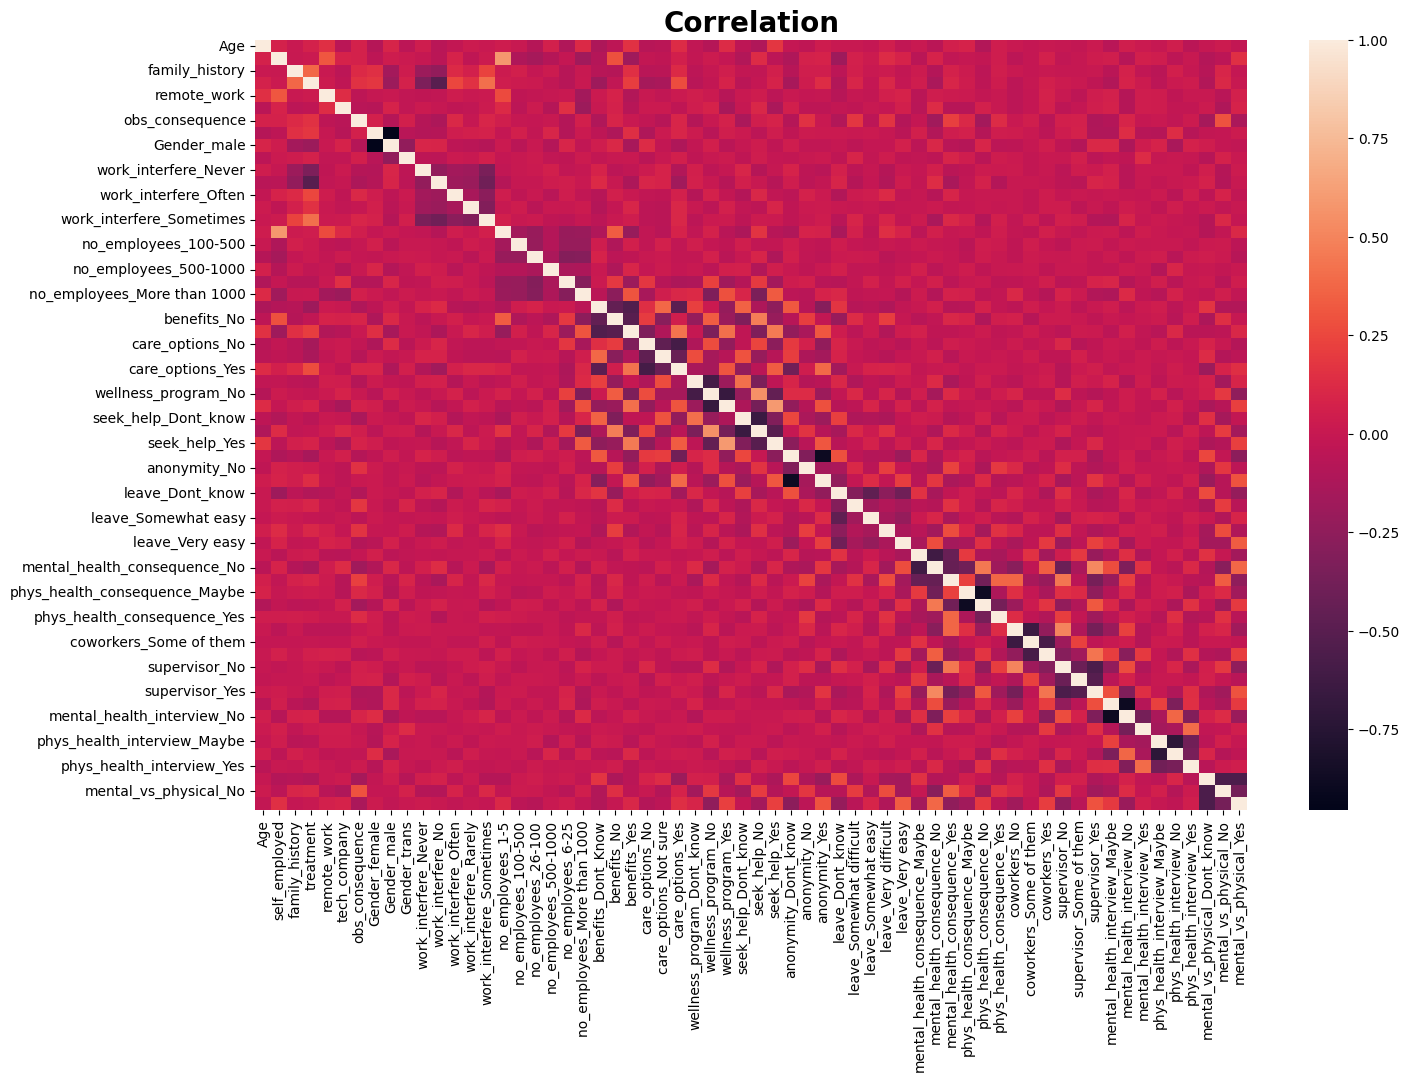

In [14]:
# Correlation heatmap of dataset
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df_final.corr(),annot=False)
plt.title("Correlation",size=20, fontweight="bold")
plt.show()

[Text(0, 0, '260'), Text(0, 0, '4')]

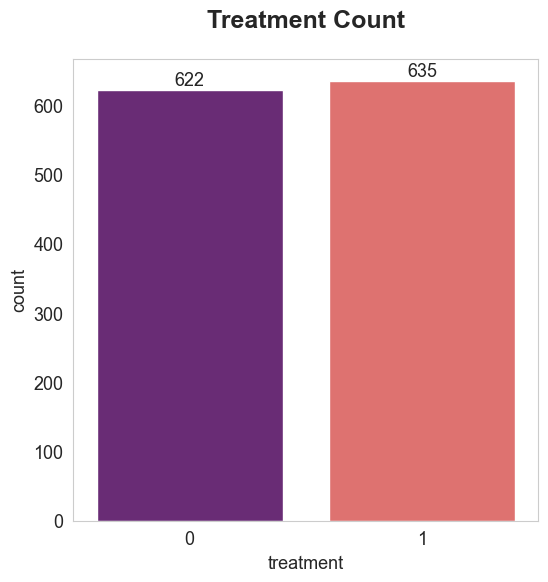

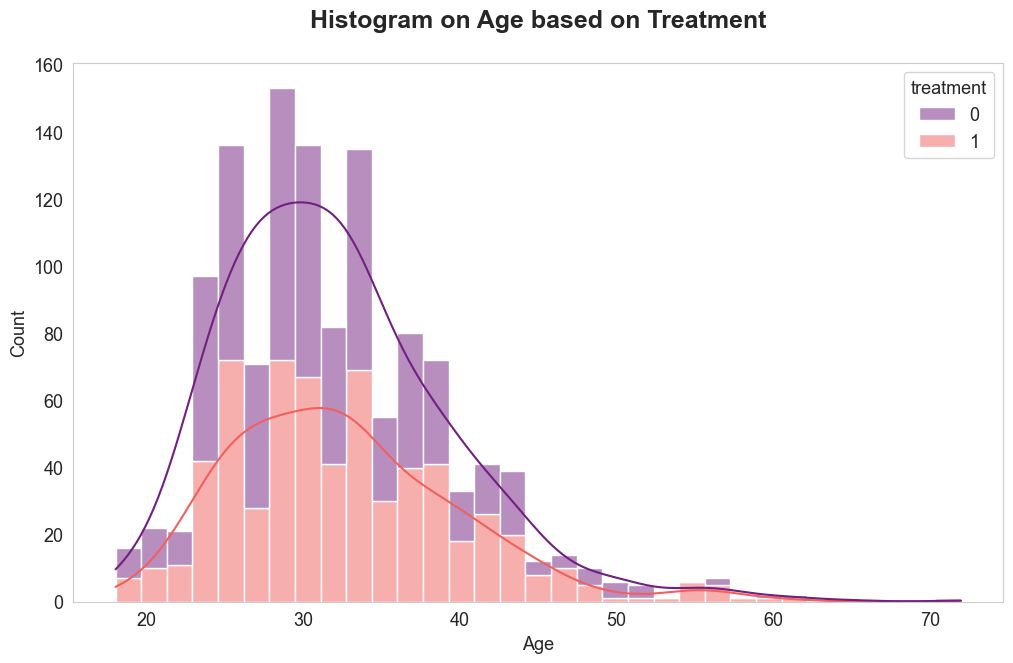

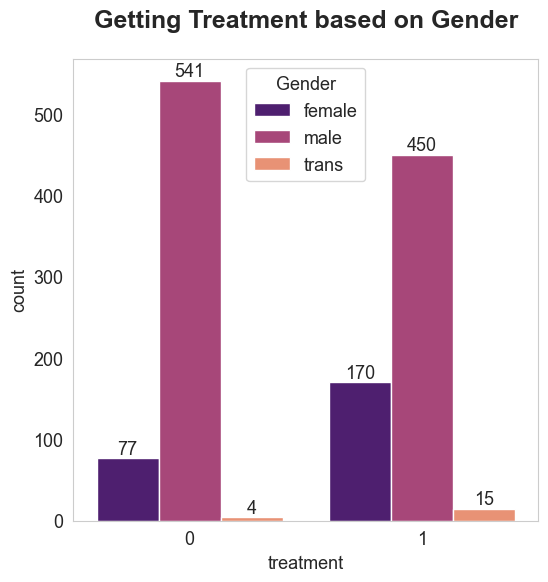

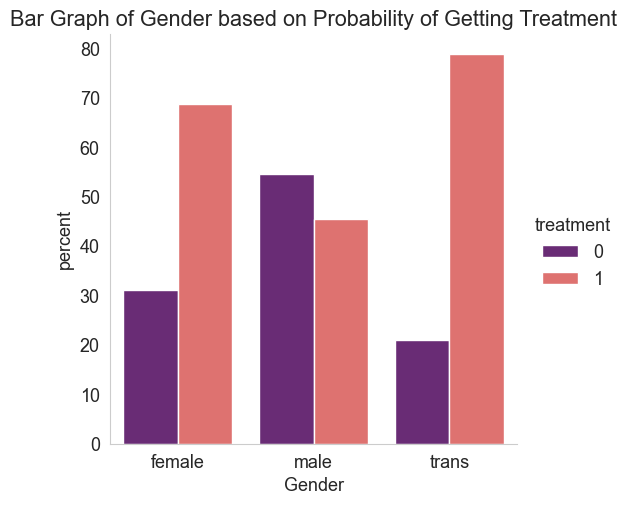

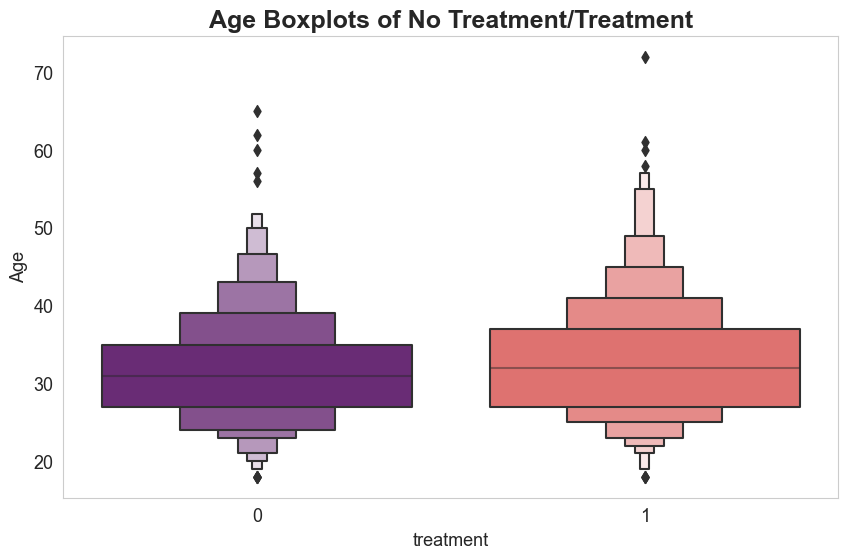

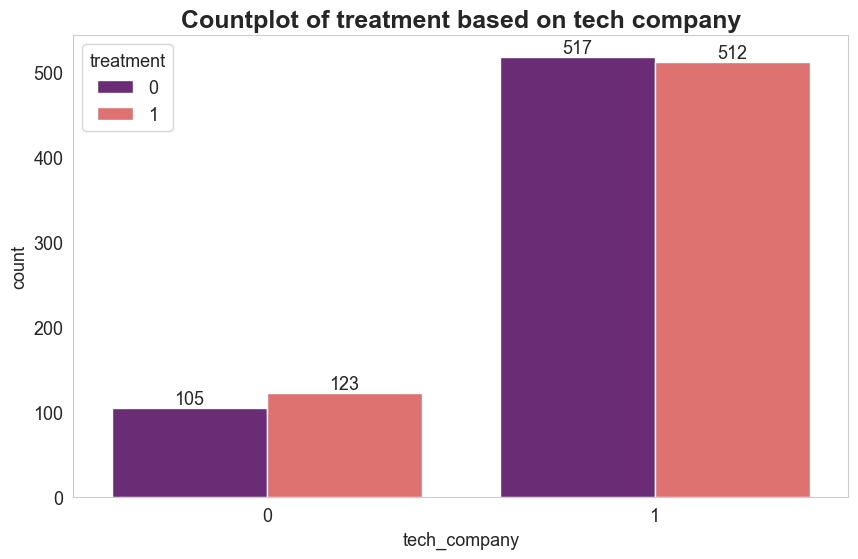

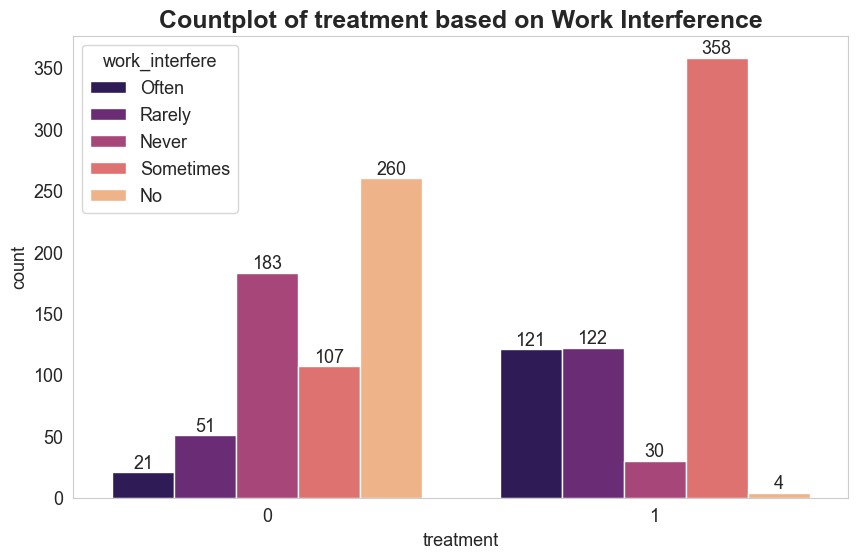

In [51]:
# Visuals of Dataset
# CountPlot of whether people get treatment or not
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.countplot(data = df_final, x = 'treatment', palette="magma")
plt.title("Treatment Count", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[0])
# Histogram of age based on treatment
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.histplot(data = df_final, x = 'Age', palette="magma", hue="treatment", kde= True, multiple= "stack")
plt.title("Histogram on Age based on Treatment", size=18, fontweight="bold", x=0.5, y=1.05)
# CountPlot of whether people get treatment or not based on Gender
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.countplot(data = df_final, x = 'treatment', hue="Gender", palette="magma")
plt.title("Getting Treatment based on Gender", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
# Bar Graph of Gender based on Treatment
(df_final
.groupby("Gender")["treatment"]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x="Gender",y='percent',hue="treatment",kind='bar',palette='magma'))
plt.title("Bar Graph of Gender based on Probability of Getting Treatment")
# Boxplot of Age based on Treatment
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.boxenplot(data = df_final, x = "treatment", y="Age", palette= "magma")
plt.title("Age Boxplots of No Treatment/Treatment",size=18, fontweight="bold")
# Countplot of treatment based on tech comapny
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.countplot(data = df_final, x = "tech_company", hue="treatment", palette= "magma")
plt.title("Countplot of treatment based on tech company",size=18, fontweight="bold")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
# Countplot of treatment based on work interference
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.countplot(data = df, x = "treatment", hue="work_interfere", palette= "magma")
plt.title("Countplot of treatment based on Work Interference",size=18, fontweight="bold")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3])
ax.bar_label(ax.containers[4])


Overall employees that go to get treatment is slightly more than those who don't get treatment. The overall median of the age of employees is around 30. Females and Trans workers are more likely to get treatment than males. Also those who get treatment find that their mental health is sometimes interfering with work.

### Setting up Analysis

In [22]:
# Setting up data for test/train data split
x= df_final[['Age','self_employed', 'family_history', 'remote_work', 'tech_company', 'obs_consequence',
       'Gender_female', 'Gender_male', 'Gender_trans',
       'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',
       'work_interfere_Sometimes', 'no_employees_1-5', 'no_employees_100-500',
       'no_employees_26-100', 'no_employees_500-1000', 'no_employees_6-25',
       'no_employees_More than 1000', "benefits_Dont_Know", 'benefits_No',
       'benefits_Yes', 'care_options_No', 'care_options_Not sure',
       'care_options_Yes', 'wellness_program_Dont_know',
       'wellness_program_No', 'wellness_program_Yes', 'seek_help_Dont_know',
       'seek_help_No', 'seek_help_Yes', 'anonymity_Dont_know', 'anonymity_No',
       'anonymity_Yes', 'leave_Dont_know', 'leave_Somewhat difficult',
       'leave_Somewhat easy', 'leave_Very difficult', 'leave_Very easy',
       'mental_health_consequence_Maybe', 'mental_health_consequence_No',
       'mental_health_consequence_Yes', 'phys_health_consequence_Maybe',
       'phys_health_consequence_No', 'phys_health_consequence_Yes',
       'coworkers_No', 'coworkers_Some of them', 'coworkers_Yes',
       'supervisor_No', 'supervisor_Some of them', 'supervisor_Yes',
       'mental_health_interview_Maybe', 'mental_health_interview_No',
       'mental_health_interview_Yes', 'phys_health_interview_Maybe',
       'phys_health_interview_No', 'phys_health_interview_Yes',
       'mental_vs_physical_Dont_know', 'mental_vs_physical_No',
       'mental_vs_physical_Yes']]
y= df_final["treatment"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)


### Logistic Regression Model

Classification report for Logistic Regression
               precision    recall  f1-score   support

           0       0.82      0.78      0.80       144
           1       0.82      0.86      0.84       171

    accuracy                           0.82       315
   macro avg       0.82      0.82      0.82       315
weighted avg       0.82      0.82      0.82       315

Accuracy score of Logistic Regression 0.82


c:\Users\halan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


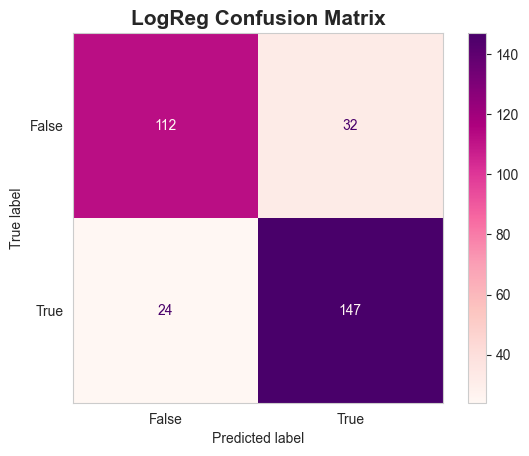

<Figure size 1000x1000 with 0 Axes>

In [23]:
# General Logistic Regression Model for entire dataset
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print("Classification report for Logistic Regression\n",classification_report(y_test,predictions))
logmodel.score(X_test,y_test)
y_pred=logmodel.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(cmap = "RdPu")
plt.rcParams.update({"font.size":12})
acc1 = accuracy_score(y_test, y_pred)
print("Accuracy score of Logistic Regression",round(acc1,2))
plt.title("LogReg Confusion Matrix", size = 15, fontweight="bold")
plt.figure(figsize=(10,10))
plt.show()

The overall accuracy of the Logistic Regression comes out to be 82%.
The f1 score for no treatment and treatment turned out to be 80% and 84%, which is good meaning that the prediction was efficient.

In [24]:
# What if we only try to look based on Gender?
# Setting up the data
genderlist = ["male","female"]
varlist= ['Age','self_employed', 'family_history', 'remote_work', 'tech_company', 'obs_consequence',
       'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',
       'work_interfere_Sometimes', 'no_employees_1-5', 'no_employees_100-500',
       'no_employees_26-100', 'no_employees_500-1000', 'no_employees_6-25',
       'no_employees_More than 1000', "benefits_Dont_Know", 'benefits_No',
       'benefits_Yes', 'care_options_No', 'care_options_Not sure',
       'care_options_Yes', 'wellness_program_Dont_know',
       'wellness_program_No', 'wellness_program_Yes', 'seek_help_Dont_know',
       'seek_help_No', 'seek_help_Yes', 'anonymity_Dont_know', 'anonymity_No',
       'anonymity_Yes', 'leave_Dont_know', 'leave_Somewhat difficult',
       'leave_Somewhat easy', 'leave_Very difficult', 'leave_Very easy',
       'mental_health_consequence_Maybe', 'mental_health_consequence_No',
       'mental_health_consequence_Yes', 'phys_health_consequence_Maybe',
       'phys_health_consequence_No', 'phys_health_consequence_Yes',
       'coworkers_No', 'coworkers_Some of them', 'coworkers_Yes',
       'supervisor_No', 'supervisor_Some of them', 'supervisor_Yes',
       'mental_health_interview_Maybe', 'mental_health_interview_No',
       'mental_health_interview_Yes', 'phys_health_interview_Maybe',
       'phys_health_interview_No', 'phys_health_interview_Yes',
       'mental_vs_physical_Dont_know', 'mental_vs_physical_No',
       'mental_vs_physical_Yes']

Classification report for male:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78        95
           1       0.78      0.86      0.82       104

    accuracy                           0.80       199
   macro avg       0.80      0.80      0.80       199
weighted avg       0.80      0.80      0.80       199

Accuracy for male: 0.8


c:\Users\halan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


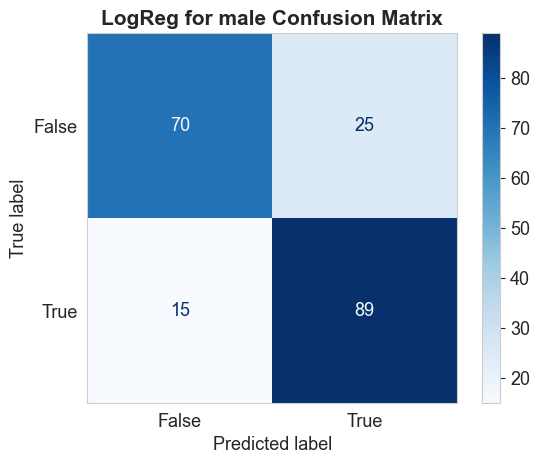

<Figure size 1000x1000 with 0 Axes>

c:\Users\halan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for female:
               precision    recall  f1-score   support

           0       0.80      0.63      0.71        19
           1       0.80      0.90      0.85        31

    accuracy                           0.80        50
   macro avg       0.80      0.77      0.78        50
weighted avg       0.80      0.80      0.79        50

Accuracy for female: 0.8


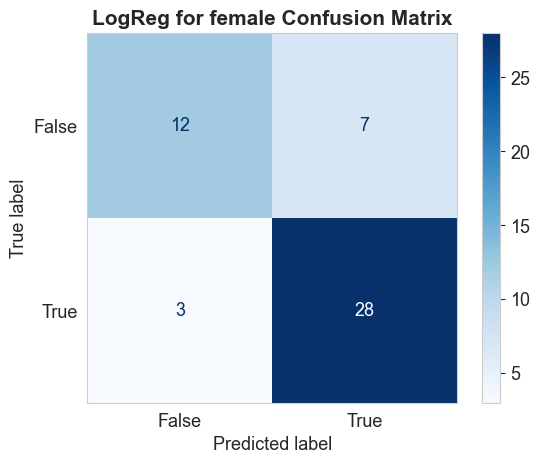

<Figure size 1000x1000 with 0 Axes>

In [52]:
# Logistic regression based on Gender, did not do trans because of the little amount of data provided, can't predict
for gender in genderlist:
    xm = df_final[df_final["Gender"]== gender][varlist]
    ym= df_final[df_final["Gender"]== gender]["treatment"]
    xm_train, xm_test, ym_train, ym_test = train_test_split(xm, ym, test_size=0.20, random_state=55)
    #Setting up logistic regression
    logmodel= LogisticRegression()
    logmodel.fit(xm_train,ym_train)
    predictions = logmodel.predict(xm_test)
    print("Classification report for {}:\n".format(gender),classification_report(ym_test,predictions))
    logmodel.score(xm_test,ym_test)
    ym_pred=logmodel.predict(xm_test)
    confusion_matrix = metrics.confusion_matrix(ym_test, ym_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot(cmap = "Blues")
    plt.rcParams.update({"font.size":13})
    acc1 = accuracy_score(ym_test, ym_pred)
    print("Accuracy for {}:".format(gender),round(acc1,2))
    plt.title("LogReg for {} Confusion Matrix".format(gender),size = 15, fontweight="bold")
    plt.figure(figsize=(10,10))
    plt.show()

Accuracy for both models is 80%, with about 80% f1 score for all. The prediction came out with more values for males than females since there are more males in the dataset

Classification report for Logistic Regression
               precision    recall  f1-score   support

           0       0.89      0.76      0.82       144
           1       0.82      0.92      0.87       171

    accuracy                           0.85       315
   macro avg       0.86      0.84      0.84       315
weighted avg       0.85      0.85      0.85       315

Accuracy score of Logistic Regression 0.85


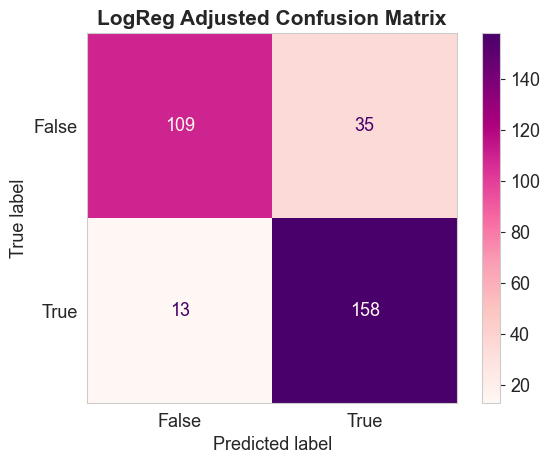

<Figure size 1000x1000 with 0 Axes>

In [53]:
# What if we limit the amount of variables we use, based on the our R analysis, The following variables used have a high correlation with treatment
# Setting up the variables
xnew = df_final[["Gender_male","family_history","work_interfere_No","work_interfere_Often",
                 "work_interfere_Rarely","work_interfere_Sometimes","benefits_Yes","care_options_Yes","coworkers_Yes"]]
ynew = df_final["treatment"]
xn_train, xn_test, yn_train, yn_test = train_test_split(xnew, ynew, test_size=0.25, random_state=55)
# Setting up the model
lmnew = LogisticRegression()
lmnew.fit(xn_train,yn_train)
pnew = lmnew.predict(xn_test)
print("Classification report for Logistic Regression\n",classification_report(yn_test,pnew))
lmnew.score(xn_test,yn_test)
yprednew=lmnew.predict(xn_test)
confusion_matrix = metrics.confusion_matrix(yn_test, yprednew)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(cmap = "RdPu")
plt.rcParams.update({"font.size":12})
acc1 = accuracy_score(yn_test, yprednew)
print("Accuracy score of Logistic Regression",round(acc1,2))
plt.title("LogReg Adjusted Confusion Matrix", size = 15, fontweight="bold")
plt.figure(figsize=(10,10))
plt.show()

The accuracy for this logistic regression model is higher than the other models since it is not overfitting variables and has only 9 dependent variables. There is an overall accuracy of 85% with a precision of 89% on No treatment and 82% on treatment. 

In [57]:
# Cross validation score
cvscore = cross_val_score(logmodel, x,y, cv = 10)
meanscore = mean(cvscore)
print("Cross validation score of logistic regression model of entire dataset\n",cvscore)
print("\nAverage score for entire dataset",round(meanscore,2))
cvscore2 = cross_val_score(lmnew, xnew,ynew, cv = 10)
meanscore2 = mean(cvscore2)
print("\nCross validation score of logistic regression model of adjusted dataset\n",cvscore2)
print("\nAverage score for adjusted dataset",round(meanscore2,2))

c:\Users\halan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\halan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross validation score of logistic regression model of entire dataset
 [0.81746032 0.82539683 0.82539683 0.83333333 0.86507937 0.82539683
 0.83333333 0.888      0.792      0.8       ]

Average score for entire dataset 0.83

Cross validation score of logistic regression model of adjusted dataset
 [0.81746032 0.82539683 0.85714286 0.84126984 0.84920635 0.8015873
 0.85714286 0.872      0.808      0.784     ]

Average score for adjusted dataset 0.83


### XGBoost Model

Accuracy for XGBoost model: 0.84
Classification report for XGBoost:
               precision    recall  f1-score   support

           0       0.85      0.78      0.82       144
           1       0.83      0.88      0.86       171

    accuracy                           0.84       315
   macro avg       0.84      0.83      0.84       315
weighted avg       0.84      0.84      0.84       315



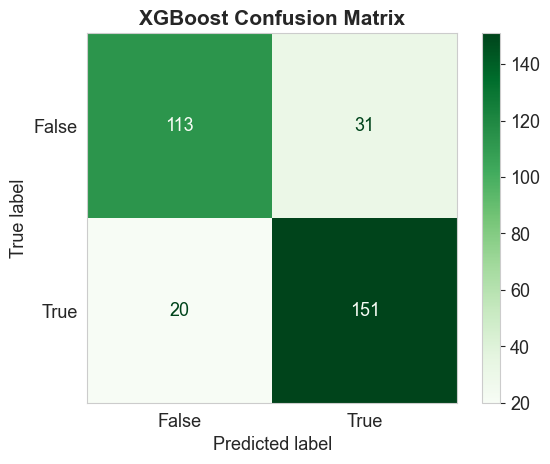

<Figure size 1000x1000 with 0 Axes>

In [38]:
# Setting up model for XGBoost using previous x and y values for train/test set
modelx = XGBClassifier()
modelx.fit(X_train,y_train)
yx_pred= modelx.predict(X_test)
print("Accuracy for XGBoost model:", round(accuracy_score(y_test,yx_pred),2))
print("Classification report for XGBoost:\n",classification_report(y_test,yx_pred))
cmx = metrics.confusion_matrix(y_test, yx_pred)
cmdx = metrics.ConfusionMatrixDisplay(confusion_matrix = cmx, display_labels = [False, True])
cmdx.plot(cmap = "Greens")
plt.rcParams.update({"font.size":13})
plt.title("XGBoost Confusion Matrix", size = 15, fontweight="bold")
plt.figure(figsize=(10,10))
plt.show()

The overall accuracy is 84% with an f1 score for 0.82 and 0.86 for no treatment and treatment.

### Random Forest Classifier Model

Accuracy for RandomForestClassifier: 0.82
Classification report for RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79       144
           1       0.82      0.85      0.83       171

    accuracy                           0.82       315
   macro avg       0.82      0.81      0.81       315
weighted avg       0.82      0.82      0.82       315



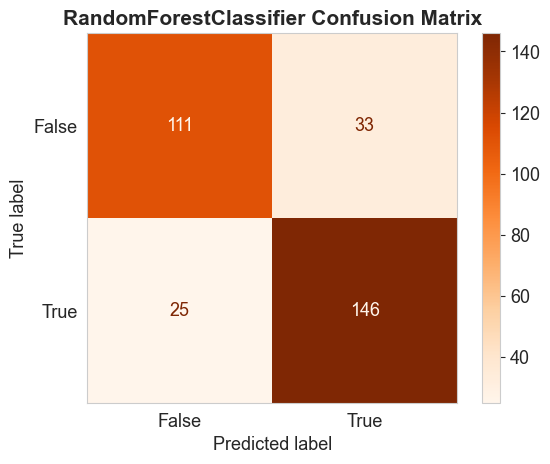

<Figure size 1000x1000 with 0 Axes>

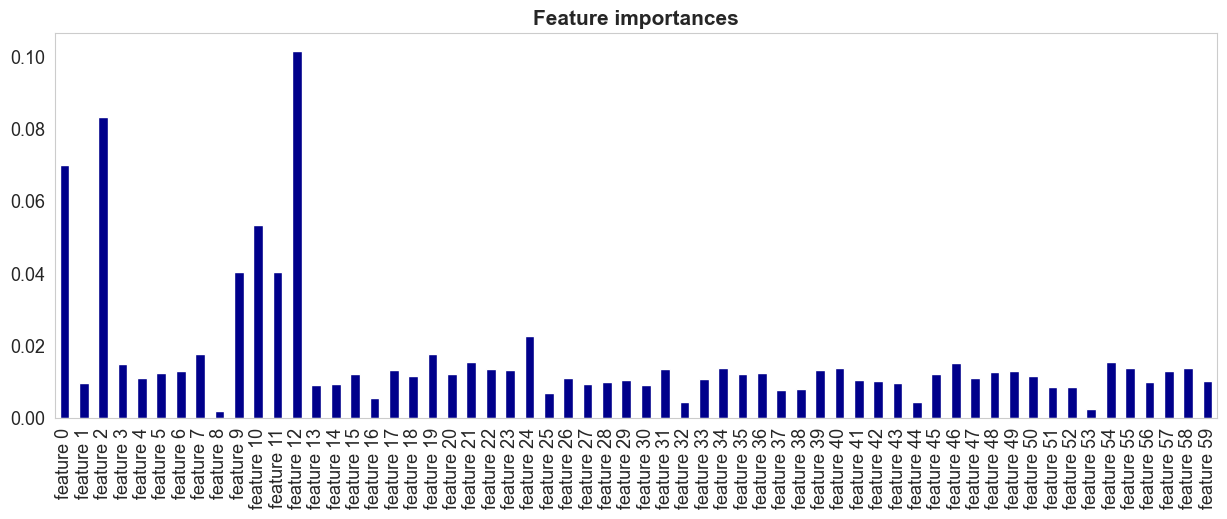

In [23]:
# Random Forest Classifier Model
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
yrf_pred = rfc.predict(X_test)
print("Accuracy for RandomForestClassifier:",round(accuracy_score(y_test,yrf_pred),2))
print("Classification report for RandomForestClassifier:\n",classification_report(y_test,yrf_pred))
cmr = metrics.confusion_matrix(y_test, yrf_pred)
cmrd = metrics.ConfusionMatrixDisplay(confusion_matrix = cmr, display_labels = [False, True])
cmrd.plot(cmap = "Oranges")
plt.rcParams.update({"font.size":13})
plt.title("RandomForestClassifier Confusion Matrix", size = 15, fontweight="bold")
plt.figure(figsize=(10,10))
plt.show()
importances = rfc.feature_importances_
feature_names = [f"feature {i}" for i in range(x.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,5))
forest_importances.plot.bar(ax=ax, color="DarkBlue")
plt.title("Feature importances", size = 15, fontweight="bold")
plt.show()

The Random Forest Classifier Model comes out with an accuracy of 83% and an f1 score of 81% and 85% for getting no treatment and getting treatment predictions

In [24]:
#Looking at top five features for dataset
x.columns[[0,2,9,10,12]]


Index(['Age', 'family_history', 'work_interfere_Never', 'work_interfere_Often',
       'work_interfere_Sometimes'],
      dtype='object')

Looking at this, "Work interefere sometimes" has the highest value, it means mental health interferes with your work more or less
The next column is Family History, which is a someone has a family history of mental illness
Third most column is someone's age. These three variables are the top three reasons that may impact someone to go get treatment